In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append('../lib')
from storage import get_storage_functions, quantize
from local_paths import preproc_dir, analysis_dir
from self_consistency import \
    find_return_fixations, pairwise_self_consistency, \
    pairwise_self_consistency_perm_test

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# response windows
#============================================================================
t_pre  = 375
t_post = 375
t_step =  10


#============================================================================
# return fixation selection
#============================================================================
return_thres =   1  # for defining "return fixation"; can set to typical radius of rf

# "decorrelate" return fixations:
#   sub-select only return pairs where the non-return fixations
#   (e.g., "prev" for "curr return") are this far apart
min_sep      =   4  # dva; only consider saccades at least this large
min_sep_win  = 100


#============================================================================
# rsc options
#============================================================================
n_boots = 200


#============================================================================
# statistical tests
#============================================================================
stat_tests = (
    ('previous', 'current', 'greater'),
    ('previous', 'current', 'less'))
n_perm = 10000
save_perm_diffs = False  # whether to save permuted delta effect sizes


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
sdf_dir = preproc_dir
sdf_suffix = '-mwa_50'

output_dir = analysis_dir + 'self_consistency'

In [3]:
# Parameters
sess_name = "Pa210201"
sdf_suffix = "-mwa_50-hg"
output_dir = "../test_results/hier_group"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50-hg.h5
Saving results to ../test_results/hier_group/Pa210201.h5


In [5]:
analysis_name = 'self_consistency'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
do_tests = len(stat_tests) and n_perm

if do_tests:
    stat_tests_ = []
    stat_tests_ordered = []
    for test in stat_tests:
        c0, c1 = test[:2]
        alt = test[2] if len(test) > 2 else 'two-sided'
        assert alt in ('less', 'greater', 'two-sided')
        stat_tests_.append((c0, c1, alt))
        if c0 > c1:
            c0, c1 = c1, c0
            if alt != 'two-sided':
                alt = dict(less='greater', greater='less')[alt]
        stat_tests_ordered.append((c0, c1, alt))

    stat_tests = tuple(stat_tests_)
    stat_tests_ordered = pd.DataFrame(stat_tests_ordered, columns=['Condition 1', 'Condition 2', 'Alternative'])
    stat_tests_ordered = stat_tests_ordered.reset_index().set_index(['Condition 1', 'Condition 2'])

    print(stat_tests)
    stat_tests_ordered

else:
    stat_tests = stat_tests_ordered = None

(('previous', 'current', 'greater'), ('previous', 'current', 'less'))


# Save config

In [7]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    sacc_sel = f['saccade_selection/fixation_indices'][()]
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

print('random_seed:', random_seed)

random_seed: 775418045


In [8]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [9]:
group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)
save_results(group+'sdf_suffix', sdf_suffix)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/return_criterion/'
save_results(group+'return_thres', return_thres, attrs=dict(unit='dva'))
save_results(group+'min_sep', min_sep, attrs=dict(unit='dva'))
save_results(group+'min_sep_win', min_sep_win, attrs=dict(unit='ms'))

group = analysis_name + '/config/statistics/'
save_results(group+'tests', str(stat_tests))
save_results(group+'test_kind', 'permutation')
save_results(group+'n_perm', n_perm)

save_results(analysis_name+'/saccade_selection', sacc_sel)

# Find return pairs

In [10]:
df_ = fix_df.iloc[sacc_sel[1]]
imids = np.array([f'{v0}/{v1}' for v0, v1 in df_[['Image subdir', 'Image filename']].values])
pos0 = fix_df.iloc[sacc_sel[0]][['Relative X', 'Relative Y']].values
pos1 = df_[['Relative X', 'Relative Y']].values

curr_return_pairs = find_return_fixations(imids, pos1, thres_deg=return_thres)
prev_return_pairs = find_return_fixations(imids, pos0, thres_deg=return_thres)
print('"current" return pairs shape:', curr_return_pairs.shape)
print('"previous" return pairs shape:', prev_return_pairs.shape)

bycond_return_pairs = dict(
    current=curr_return_pairs,
    previous=prev_return_pairs)

"current" return pairs shape: (1449, 2)
"previous" return pairs shape: (1011, 2)


In [11]:
if min_sep > 0:
    iind_tr = fix_df.index.names.index('Trial')
    iind_fix = fix_df.index.names.index('Fixation')

    for cond, return_pairs in bycond_return_pairs.items():
        decorr_win = 'current' if cond == 'previous' else 'previous'
        min_seps = np.full(len(return_pairs), np.inf)

        for i, (i0_, i1_) in enumerate(tqdm(return_pairs)):
            i0, i1 = sacc_sel[1,[i0_,i1_]]
            itr0, itr1 = fix_df.index.get_level_values(iind_tr)[[i0,i1]]
            tr0_fixs = fix_df.loc[(itr0, slice(None))]
            tr1_fixs = fix_df.loc[(itr1, slice(None))]

            # find any relevant fixations within min_sep window
            if decorr_win == 'current':
                ifix0, ifix1 = fix_df.index.get_level_values(iind_fix)[[i0,i1]]
                t0, t1 = fix_df.iloc[[i0,i1]]['Time'].values

                m0 = tr0_fixs.index >= ifix0
                if not m0.any(): continue
                m0[m0] = tr0_fixs.loc[m0, 'Time'] <= (t0 + min_sep_win)
                if not m0.any(): continue

                m1 = tr1_fixs.index >= ifix1
                if not m1.any(): continue
                m1[m1] = tr1_fixs.loc[m1, 'Time'] <= (t1 + min_sep_win)
                if not m1.any(): continue

            else:
                i0, i1 = sacc_sel[0,[i0_,i1_]]
                ifix0, ifix1 = fix_df.index.get_level_values(iind_fix)[[i0,i1]]
                t0, t1 = fix_df.iloc[[i0,i1]]['End time'].values

                m0 = tr0_fixs.index <= ifix0
                if not m0.any(): continue
                m0[m0] = tr0_fixs.loc[m0, 'End time'].values > (t0 - min_sep_win)
                if not m0.any(): continue

                m1 = tr1_fixs.index <= ifix1
                if not m1.any(): continue
                m1[m1] = tr1_fixs.loc[m1, 'End time'].values > (t1 - min_sep_win)
                if not m1.any(): continue

            pwd = np.linalg.norm(
                tr0_fixs.loc[m0, ['Relative X', 'Relative Y']].values[:,None,:]
                - tr1_fixs.loc[m1, ['Relative X', 'Relative Y']].values[None,:,:],
                axis=-1)
            min_seps[i] = pwd.min()

        bycond_return_pairs[cond] = return_pairs[min_seps >= min_sep]

    for k, v in bycond_return_pairs.items():
        print(f'decorrelated "{k}" return pairs shape:', v.shape)

100%|██████████████████████████████████████| 1449/1449 [00:02<00:00, 526.93it/s]

100%|██████████████████████████████████████| 1011/1011 [00:02<00:00, 499.44it/s]

decorrelated "current" return pairs shape: (770, 2)
decorrelated "previous" return pairs shape: (497, 2)


In [12]:
group = analysis_name + '/return_pairs/'
for cond, pairs in bycond_return_pairs.items():
    if not pairs.size:
        pairs = h5.Empty('i')
    save_results(group+cond, pairs)

# Get fixation onset-aligned responses

In [13]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    unit_names = dset.attrs['unit_names'].astype(str)
    sdf = dset[()]
    if 'unit_names' in f:
        copy_group(f, 'unit_names', analysis_name+'/unit_names')

n_neur = sdf.shape[1]
unit_names.shape, unit_names.dtype, sdf.shape, sdf.dtype

((106,), dtype('<U10'), (6234150, 106), dtype('float32'))

In [14]:
ts = np.arange(-t_pre, t_post, t_step)

resps = np.empty_like(sdf, shape=(sacc_sel.shape[1], ts.size, sdf.shape[-1]))
for i, t in enumerate(fix_df.iloc[sacc_sel[1]]['Time'].values):
    ts_ = np.round(t+ts).astype(int)
    resps[i] = sdf[ts_,:]

resps.shape, resps.dtype

((4037, 75, 106), dtype('float32'))

# Calculate self-consistency

In [15]:
coords = (('time', ts), ('unit', unit_names))
attrs = dict(
    return_thres=return_thres,
    min_sep=min_sep,
    min_sep_win=min_sep_win,
    random_seed=random_seed,
    unit="Pearson's r")

bycond_rsc_ds = {}
for cond, pairs in bycond_return_pairs.items():
    if len(pairs) > 1:
        attrs['n_pairs'] = len(pairs)
        ds = pairwise_self_consistency(
            pairs=pairs, resps=resps,
            n_bootstraps=n_boots, n_permutations=0,
            random_seed=random_seed,
            coords=coords, attrs=attrs)
    else:
        ds = None
    bycond_rsc_ds[cond] = ds

In [16]:
group = analysis_name + '/'
q = lambda x: quantize(x, 3)
compr = dict(zlib=True, complevel=9)
for cond, dataset in bycond_rsc_ds.items():
    loc = group + cond
    if dataset is not None:
        dataset = dataset.assign({
            k: q(v)
            for k, v in dataset.data_vars.items()})
        encoding = {
            k: dict(chunksizes=v.shape, **compr)
            for k, v in dataset.data_vars.items()
            if v.size}
        dataset.to_netcdf(
            output_path, group=loc, mode='a',
            engine='h5netcdf', encoding=encoding)
    else:
        save_results(loc, h5.Empty('f'))

# Permutation test

In [17]:
test_results = {}

if do_tests:
    coords = (('time', ts), ('unit', unit_names))
    attrs = dict(random_seed=random_seed)

    for (c0, c1), rows in stat_tests_ordered.groupby(['Condition 1', 'Condition 2'], axis=0):
        alts = rows['Alternative'].values
        print('test:', (c0, c1), '\talternatives:', alts)

        try:
            ds = pairwise_self_consistency_perm_test(
                resps=resps,
                pairs0=bycond_return_pairs[c0],
                pairs1=bycond_return_pairs[c1],
                alternatives=alts,
                n_permutations=n_perm,
                random_seed=random_seed,
                coords=coords,
                attrs=attrs,
                verbose=True)
        except ValueError as e:
            if 'Less than 2 pairs' in str(e):
                continue
            raise

        test_results[(c0,c1)] = ds
        print()

test: ('current', 'previous') 	alternatives: ['less' 'greater']
calculating self consistency permutation distribution w.r.t. pairing conditions
10000 permutations


done (263.0 s)



In [18]:
group = analysis_name + '/permutation_test/'
compr = dict(zlib=True, complevel=9)
for (c0, c1), dataset in test_results.items():
    if not save_perm_diffs:
        dataset = dataset.drop_vars('permuted_diffs')
    encoding = {
        k: dict(chunksizes=v.shape, **compr)
        for k, v in dataset.data_vars.items()
        if v.size}
    dataset.to_netcdf(
        output_path, group=group+f'{c0}_v_{c1}',
        mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [19]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [20]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T22:02:57.552734-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

numpy : 1.24.3
h5py  : 3.8.0
pandas: 2.0.1
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



# Plots

In [21]:
import matplotlib.pyplot as plt

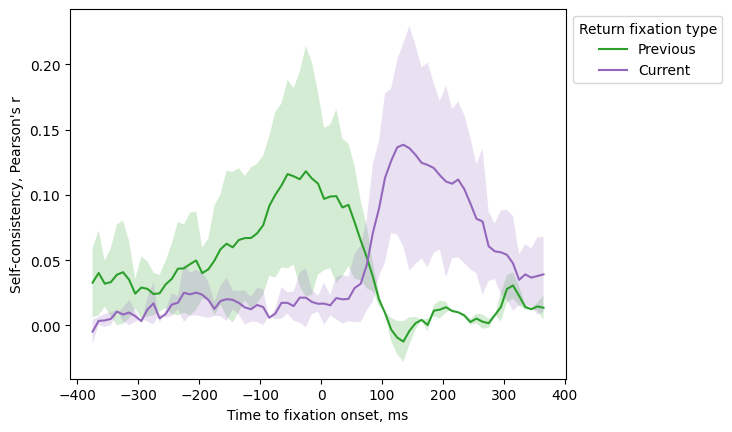

In [22]:
if any(v is not None for v in bycond_rsc_ds.values()):
    for k, color in (
            ('previous', 'tab:green'),
            ('current', 'tab:purple')):
        value = bycond_rsc_ds[k]
        if value is None: continue
        val = value['sample'].values
        m = np.nanmean(val, -1)
        s = np.nanmedian(val, -1)
        l, = plt.plot(ts, m, label=k.capitalize(), color=color)
        plt.fill_between(ts, m-s, m+s, ec='none', fc=l.get_color(), alpha=0.2)
    plt.xlabel('Time to fixation onset, ms')
    plt.ylabel('Self-consistency, Pearson\'s r')
    plt.legend(title='Return fixation type', loc='upper left', bbox_to_anchor=(1,1))

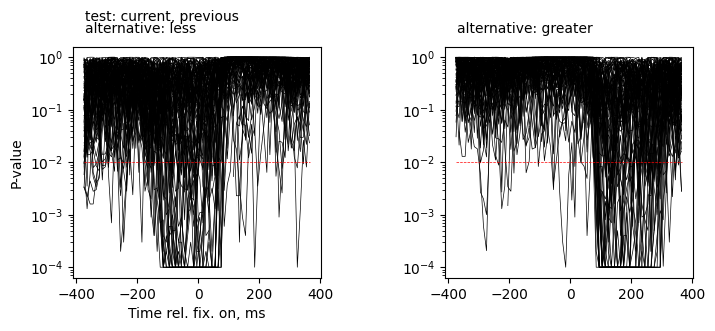

In [23]:
for test, results in test_results.items():
    alts = results.coords['alternative'].values
    n = len(alts)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False, sharex=True)
    plt.subplots_adjust(wspace=0.5)
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    pvals_ = results['p-value'].values
    for i, ax in enumerate(axs.ravel()):
        vs = pvals_[i]
        ax.plot(ts, vs, c='k', lw=0.5);
        ax.set_yscale('log')
        ax.hlines(1e-2, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
        ax.text(.05, 1.05, f'alternative: {alts[i]}',
                ha='left', va='bottom', transform=ax.transAxes)
    ax = axs[0,0]
    ax.text(.05, 1.1, 'test: '+', '.join(map(f, test)),
            ha='left', va='bottom', transform=ax.transAxes)
    axs[-1,0].set_xlabel('Time rel. fix. on, ms')
    axs[0,0].set_ylabel('P-value');

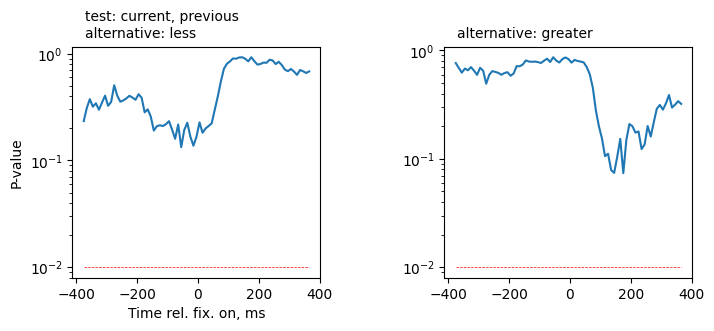

In [24]:
for test, results in test_results.items():
    alts = results.coords['alternative'].values
    n = len(alts)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False, sharex=True)
    plt.subplots_adjust(wspace=0.5)
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    pvals_ = results['p-value'].values
    for i, ax in enumerate(axs.ravel()):
            vs = pvals_[i]
            ax.plot(ts, np.nanmedian(vs, axis=-1))
            ax.set_yscale('log')
            ax.hlines(1e-2, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
            ax.text(.05, 1.025, f'alternative: {alts[i]}',
                    ha='left', va='bottom', transform=ax.transAxes)
    ax = axs[0,0]
    ax.text(.05, 1.1, 'test: '+', '.join(map(f, test)),
            ha='left', va='bottom', transform=ax.transAxes)
    axs[-1,0].set_xlabel('Time rel. fix. on, ms')
    axs[0,0].set_ylabel('P-value');